In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


In [2]:
import os


initial_path = '/Users/abhaay/Coding Shoding/Project/Data'

# Define the new top-level directory names
directories = ['train', 'val', 'test']

# Define the subdirectory names for each top-level directory
subdirectories = ['Cancer','Negative']

# Define the proportions for train, validation, and test sets
props = [0.9, 0.05, 0.05]

# Loop over the top-level directories and subdirectories, and create the corresponding directories
for directory in directories:
    for subdirectory in subdirectories:
        path = os.path.join(initial_path, subdirectory)
        files = os.listdir(path)
        random.shuffle(files)
        total = len(files)
        train_end = int(total * props[0])
        val_end = train_end + int(total * props[1])
        if directory == 'train':
            new_files = files[:train_end]
        elif directory == 'val':
            new_files = files[train_end:val_end]
        else:
            new_files = files[val_end:]
        new_path = os.path.join(directory, subdirectory)
        os.makedirs(new_path, exist_ok=True)
        for file in new_files:
            old_file_path = os.path.join(path, file)
            new_file_path = os.path.join(new_path, file)
            shutil.copy(old_file_path, new_file_path)

In [3]:
train_dir = 'train'
val_dir = 'val'
test_dir = "test"



# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( val_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 812 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


In [4]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-03-19 22:13:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.182.155, 142.250.193.123, 142.250.71.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.182.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

/tmp/inception_v3_w 100%[===================>]  83.84M  2.01MB/s    in 66s     

2024-03-19 22:14:27 (1.27 MB/s) - '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [87910968/87910968]



In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers


# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
#Copy InceptionV3 to pre_trained_model with changes
pre_trained_model  = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers,because they have been trained already.
for layer in pre_trained_model.layers:
  layer.trainable = False   

In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [10]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for binary classification (cat or dog)
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the Newly dense network to the base model you customize
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [12]:
# Set the training parameters
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [13]:
import tensorflow as tf

# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [24]:
EPOCHS = 20
BATCH_SIZE = 128

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            batch_size = BATCH_SIZE,
            # callbacks = [early_stopping],
            epochs = EPOCHS,
            verbose = 2)

Epoch 1/20
37/37 - 9s - loss: 0.2175 - accuracy: 0.9133 - val_loss: 0.2575 - val_accuracy: 0.9250 - 9s/epoch - 231ms/step
Epoch 2/20
37/37 - 9s - loss: 0.2095 - accuracy: 0.9079 - val_loss: 0.2315 - val_accuracy: 0.8750 - 9s/epoch - 238ms/step
Epoch 3/20
37/37 - 9s - loss: 0.1936 - accuracy: 0.9255 - val_loss: 0.2056 - val_accuracy: 0.9500 - 9s/epoch - 249ms/step
Epoch 4/20
37/37 - 9s - loss: 0.1894 - accuracy: 0.9255 - val_loss: 0.2388 - val_accuracy: 0.9250 - 9s/epoch - 237ms/step
Epoch 5/20
37/37 - 9s - loss: 0.1617 - accuracy: 0.9404 - val_loss: 0.2297 - val_accuracy: 0.9500 - 9s/epoch - 249ms/step
Epoch 6/20
37/37 - 9s - loss: 0.2014 - accuracy: 0.9201 - val_loss: 0.1411 - val_accuracy: 0.9500 - 9s/epoch - 247ms/step
Epoch 7/20
37/37 - 10s - loss: 0.2109 - accuracy: 0.9201 - val_loss: 0.1709 - val_accuracy: 0.9500 - 10s/epoch - 277ms/step
Epoch 8/20
37/37 - 10s - loss: 0.1601 - accuracy: 0.9309 - val_loss: 0.3432 - val_accuracy: 0.8750 - 10s/epoch - 265ms/step
Epoch 9/20
37/37 - 1

[0.913279116153717, 0.9078590869903564, 0.925474226474762, 0.925474226474762, 0.9403793811798096, 0.9200541973114014, 0.9200541973114014, 0.9308943152427673, 0.9308943152427673, 0.9308943152427673, 0.9471544623374939, 0.934959352016449, 0.8983739614486694, 0.9430894255638123, 0.925474226474762, 0.934959352016449, 0.925474226474762, 0.9214091897010803, 0.93360435962677, 0.9295393228530884] [0.925000011920929, 0.875, 0.949999988079071, 0.925000011920929, 0.949999988079071, 0.949999988079071, 0.949999988079071, 0.875, 0.925000011920929, 0.925000011920929, 0.949999988079071, 0.925000011920929, 0.925000011920929, 0.925000011920929, 0.824999988079071, 0.949999988079071, 0.8999999761581421, 0.8999999761581421, 0.925000011920929, 0.875]


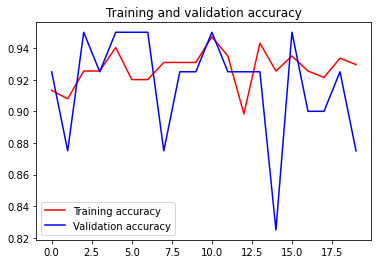

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
print(acc,val_acc)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [47]:
# Define a dictionary to convert label indices to class names
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

# Use the trained model to predict labels for the test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]
print(predicted_labels)

# Get the true labels of the test images
true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]
print(true_labels)

Found 42 images belonging to 2 classes.


42/42 [==============================] - 1s 26ms/step
['Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer']
['Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative']


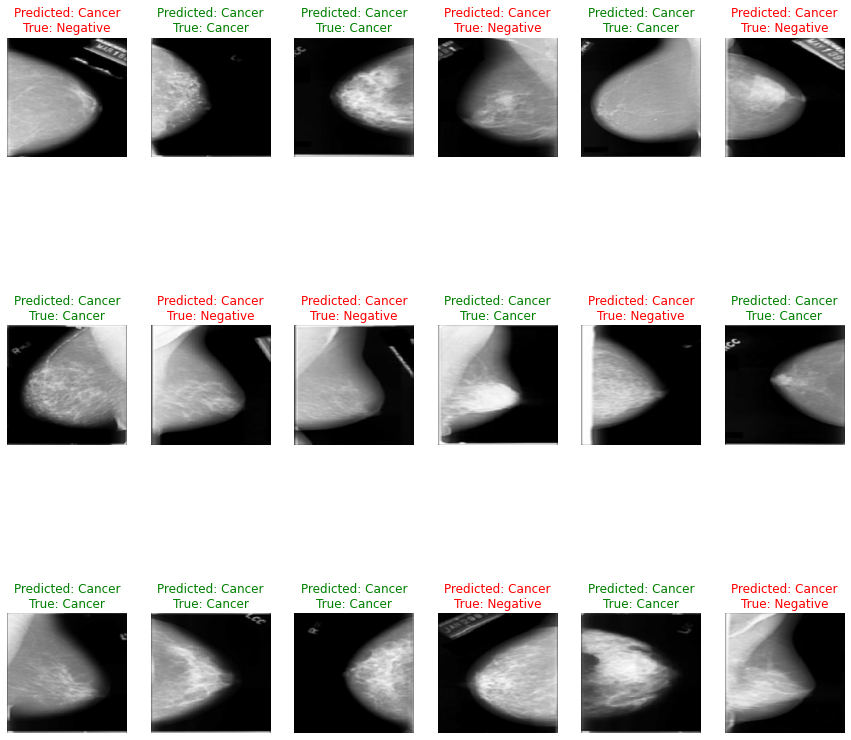

In [27]:
# Print the predicted and true labels for a subset of test images
n_rows = 3
n_cols = 6
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

np.random.seed(42)
random_indexes = np.random.choice(len(predicted_labels), size=n_rows*n_cols, replace=False)

for i, index in enumerate(random_indexes):
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(150, 150))
    axs[i//n_cols, i%n_cols].imshow(img)
    axs[i//n_cols, i%n_cols].axis('off')
    axs[i//n_cols, i%n_cols].set_title("Predicted: {}\nTrue: {}".format(predicted_labels[index], true_labels[index]), 
                      color='green' if predicted_labels[index] == true_labels[index] else 'red')
plt.show()

In [45]:
from sklearn import metrics
test_labels=["cancer","negative"]
print ("Accuracy = ", metrics.accuracy_score(true_labels,predicted_labels))

Accuracy =  0.5


In [ ]:
# https://youtu.be/9GzfUzJeyi0

"""
@author: Sreenivas Bhattiprolu
"""

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns


print(os.listdir("/Users/abhaay/Coding Shoding/Project/Data"))

SIZE = 128

train_images = []
train_labels = [] 
for directory_path in glob.glob("/Users/abhaay/Coding Shoding/Project/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


# test
test_images = []
test_labels = [] 
for directory_path in glob.glob("/Users/abhaay/Coding Shoding/Project/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#############################

activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

##########################################
#Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=50, validation_data = (x_test, y_test_one_hot))


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

#Check results on a few select images

#n=5 dog park. NN not as good as RF.
n=9  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(cnn_model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

################################
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

#Check results on a few select images
#n=5 #dog park. RF works better than CNN
n=9 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])








In [34]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/Users/abhaay/Coding Shoding/Project/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [37]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)


In [38]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded


In [39]:
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [40]:
from tensorflow.keras.layers import BatchNormalization

activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())


In [41]:
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)


In [42]:
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94_input (InputLaye  [(None, 128, 128, 3)]     0         
 r)                                                              
                                                                 
 conv2d_94 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_94 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_95 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_95 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                           

In [44]:
EPOCHS = 20
BATCH_SIZE = 128

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            batch_size = BATCH_SIZE,
            # callbacks = [early_stopping],
            epochs = EPOCHS,
            verbose = 2)

Epoch 1/20
37/37 - 8s - loss: 0.1494 - accuracy: 0.9322 - val_loss: 0.1871 - val_accuracy: 0.9000 - 8s/epoch - 229ms/step
Epoch 2/20
37/37 - 8s - loss: 0.1558 - accuracy: 0.9309 - val_loss: 0.1785 - val_accuracy: 0.9500 - 8s/epoch - 217ms/step
Epoch 3/20
37/37 - 8s - loss: 0.1767 - accuracy: 0.9309 - val_loss: 0.1847 - val_accuracy: 0.9000 - 8s/epoch - 218ms/step
Epoch 4/20
37/37 - 8s - loss: 0.1825 - accuracy: 0.9268 - val_loss: 0.1343 - val_accuracy: 0.9250 - 8s/epoch - 222ms/step
Epoch 5/20


KeyboardInterrupt: 